Imports

In [52]:
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib as plt
from matplotlib import pyplot
from sklearn.metrics import mean_absolute_error
from matplotlib import figure


Modify CSV for more features

In [53]:
df = pd.read_csv('datasets/SP500.csv')
target_column = 4

# Shift the target column by -1 to get the next row's value
df['next_day_target'] = df.iloc[:, target_column].shift(-1)

# Create new columns for previous day's features
prev_day_columns = ['open', 'high', 'low', 'close', 'volume', 'change_percent']
for column in prev_day_columns:
    df[f'prev_day_{column}'] = df[column].shift(1)

# Create new columns for previous week's features
prev_week_columns = ['open', 'high', 'low', 'close', 'volume', 'change_percent']
for column in prev_week_columns:
    df[f'prev_week_{column}'] = df[column].shift(5)

# Create new columns for previous month's features
prev_month_columns = ['open', 'high', 'low', 'close', 'volume', 'change_percent']
for column in prev_month_columns:
    df[f'prev_month_{column}'] = df[column].shift(21)  # Assuming 21 trading days in a month

# Calculate trend percentage for previous week and previous month
df['prev_week_trend_percentage'] = (df['close'] - df['prev_week_close']) / df['prev_week_close'] * 100
df['prev_month_trend_percentage'] = (df['close'] - df['prev_month_close']) / df['prev_month_close'] * 100

# Calculate previous week's volatility
df['returns'] = df['close'].pct_change()
df['prev_week_volatility'] = df['returns'].rolling(window=5).std()

# Calculate previous month's volatility
df['prev_month_volatility'] = df['returns'].rolling(window=21).std()

# Drop rows with missing values
df = df.dropna()

# Save the modified DataFrame back to a CSV file
df.to_csv('modified_file.csv', index=False)

Read modified file

In [61]:
# Read data
data = pd.read_csv('modified_file.csv')
X = data[['open', 'high', 'low', 'close', 'volume', 'change_percent',
          'prev_day_open', 'prev_day_high', 'prev_day_low', 'prev_day_close', 'prev_day_volume', 'prev_day_change_percent',
          'prev_week_open', 'prev_week_high', 'prev_week_low', 'prev_week_close', 'prev_week_volume', 'prev_week_change_percent',
          'prev_month_open', 'prev_month_high', 'prev_month_low', 'prev_month_close', 'prev_month_volume', 'prev_month_change_percent',
          'prev_week_trend_percentage', 'prev_month_trend_percentage',
          'prev_week_volatility', 'prev_month_volatility']]
y = data['next_day_target']  # Target variable
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)


Predicting next day with HistGradientBoostingRegressor

In [63]:


hgb_regressor = HistGradientBoostingRegressor(random_state=42)
hgb_regressor.fit(X_train, y_train)  # Train the model

y_pred = hgb_regressor.predict(X_test)  # Make predictions on the test set

mse_gradient_reg = mean_squared_error(y_test, y_pred)
r2_gradient_reg = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse_gradient_reg)
print("R-squared:", r2_gradient_reg)
mae_gradient_reg = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae_gradient_reg)

future_data = pd.DataFrame({
    'open': [4150.00],
    'high': [4180.00],
    'low': [4140.00],
    'close': [4175.00],
    'volume': [3500000],
    'change_percent': [0.6],
    'prev_day_open': [4140.00],
    'prev_day_high': [4160.00],
    'prev_day_low': [4135.00],
    'prev_day_close': [4150.00],
    'prev_day_volume': [3450000],
    'prev_day_change_percent': [0.2],
    'prev_week_open': [4100.00],
    'prev_week_high': [4200.00],
    'prev_week_low': [4080.00],
    'prev_week_close': [4130.00],
    'prev_week_volume': [3300000],
    'prev_week_change_percent': [0.7],
    'prev_month_open': [4000.00],
    'prev_month_high': [4250.00],
    'prev_month_low': [3950.00],
    'prev_month_close': [4050.00],
    'prev_month_volume': [3200000],
    'prev_month_change_percent': [1.2],
    'prev_week_trend_percentage': [1.09],  # Calculated: (4175.00 - 4130.00) / 4130.00 * 100
    'prev_month_trend_percentage': [3.09],  # Calculated: (4175.00 - 4050.00) / 4050.00 * 100
    'prev_week_volatility': [0.015],  # Placeholder value, replace with actual volatility if available
    'prev_month_volatility': [0.025]  # Placeholder value, replace with actual volatility if available
})
future_data_scaled = scaler_X.transform(future_data)  # Use the scaler fit on X
future_pred_scaled = hgb_regressor.predict(future_data_scaled)

# Inverse transform the predicted price to the original scale
future_pred = scaler_y.inverse_transform(future_pred_scaled.reshape(-1, 1))
print("HGB Regressor - Predicted next day stock price:", future_pred[0][0])

Mean Squared Error: 1.123330615375251e-05
R-squared: 0.999701969933242
Mean Absolute Error: 0.0012767063344930965
Linear Regression - Predicted next day stock price: 4161.660695389533


c:\Programming\Python\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [59]:
# Load the modified dataset
# Splitting the dataset into training and testing sets
data = pd.read_csv('modified_file.csv')
X = data[['open', 'high', 'low', 'close', 'volume', 'change_percent',
          'prev_day_open', 'prev_day_high', 'prev_day_low', 'prev_day_close', 'prev_day_volume', 'prev_day_change_percent',
          'prev_week_open', 'prev_week_high', 'prev_week_low', 'prev_week_close', 'prev_week_volume', 'prev_week_change_percent',
          'prev_month_open', 'prev_month_high', 'prev_month_low', 'prev_month_close', 'prev_month_volume', 'prev_month_change_percent',
          'prev_week_trend_percentage', 'prev_month_trend_percentage',
          'prev_week_volatility', 'prev_month_volatility']]
y = data['next_day_target']  # Target variable
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = scaler.fit_transform(y.values.reshape(-1, 1))
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_scaled, test_size=0.2, random_state=42)

# Initializing and training the Linear Regression model
linear_regressor = LinearRegression()
linear_regressor.fit(X_train, y_train)

# Making predictions on the test set
y_pred = linear_regressor.predict(X_test)

# Evaluating the model's performance
mse_linear_reg = mean_squared_error(y_test, y_pred)
r2_linear_reg = r2_score(y_test, y_pred)
print("Linear Regression - Mean Squared Error:", mse_linear_reg)
print("Linear Regression - R-squared:", r2_linear_reg)
mae_linear_reg = mean_absolute_error(y_test, y_pred)
print("Linear Regression - Mean Absolute Error:", mae_linear_reg)
# Preparing future data for prediction
future_data = pd.DataFrame({
    'open': [4150.00],
    'high': [4180.00],
    'low': [4140.00],
    'close': [4175.00],
    'volume': [3500000],
    'change_percent': [0.6],
    'prev_day_open': [4140.00],
    'prev_day_high': [4160.00],
    'prev_day_low': [4135.00],
    'prev_day_close': [4150.00],
    'prev_day_volume': [3450000],
    'prev_day_change_percent': [0.2],
    'prev_week_open': [4100.00],
    'prev_week_high': [4200.00],
    'prev_week_low': [4080.00],
    'prev_week_close': [4130.00],
    'prev_week_volume': [3300000],
    'prev_week_change_percent': [0.7],
    'prev_month_open': [4000.00],
    'prev_month_high': [4250.00],
    'prev_month_low': [3950.00],
    'prev_month_close': [4050.00],
    'prev_month_volume': [3200000],
    'prev_month_change_percent': [1.2],
    'prev_week_trend_percentage': [1.09],  # Calculated: (4175.00 - 4130.00) / 4130.00 * 100
    'prev_month_trend_percentage': [3.09],  # Calculated: (4175.00 - 4050.00) / 4050.00 * 100
    'prev_week_volatility': [0.015],  
    'prev_month_volatility': [0.025]  
})

# Making predictions on future data
future_data_scaled = scaler.transform(future_data)  # Use the scaler fit on X
future_pred_scaled = linear_regressor.predict(future_data_scaled)

# Inverse transform the predicted price to the original scale
future_pred = scaler.inverse_transform(future_pred_scaled.reshape(-1, 1))
print("Linear Regression - Predicted next day stock price:", future_pred[0][0])

Linear Regression - Mean Squared Error: 7.295114166477183e-06
Linear Regression - R-squared: 0.9998064538318208
Linear Regression - Mean Absolute Error: 0.0009284344681025141


c:\Programming\Python\Lib\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but MinMaxScaler was fitted without feature names
  warnings.warn(


ValueError: X has 28 features, but MinMaxScaler is expecting 1 features as input.

Random Forest Regressor

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
rff_model = RandomForestRegressor(random_state=42)
rff_model.fit(X_train, y_train)
y_pred = rff_model.predict(X_test)
mse_random_forest = mean_squared_error(y_test, y_pred)
r2_random_forest = r2_score(y_test, y_pred)
print("Mean Squared Error:", mse_random_forest)
print("R2 Score:", r2_random_forest )
mae_random_forest = mean_absolute_error(y_test, y_pred)
print("Mean Absolute Error:", mae_random_forest)

Mean Squared Error: 223.75040485435298
R2 Score: 0.999784619706975
Mean Absolute Error: 5.216486276639772


Chart Results

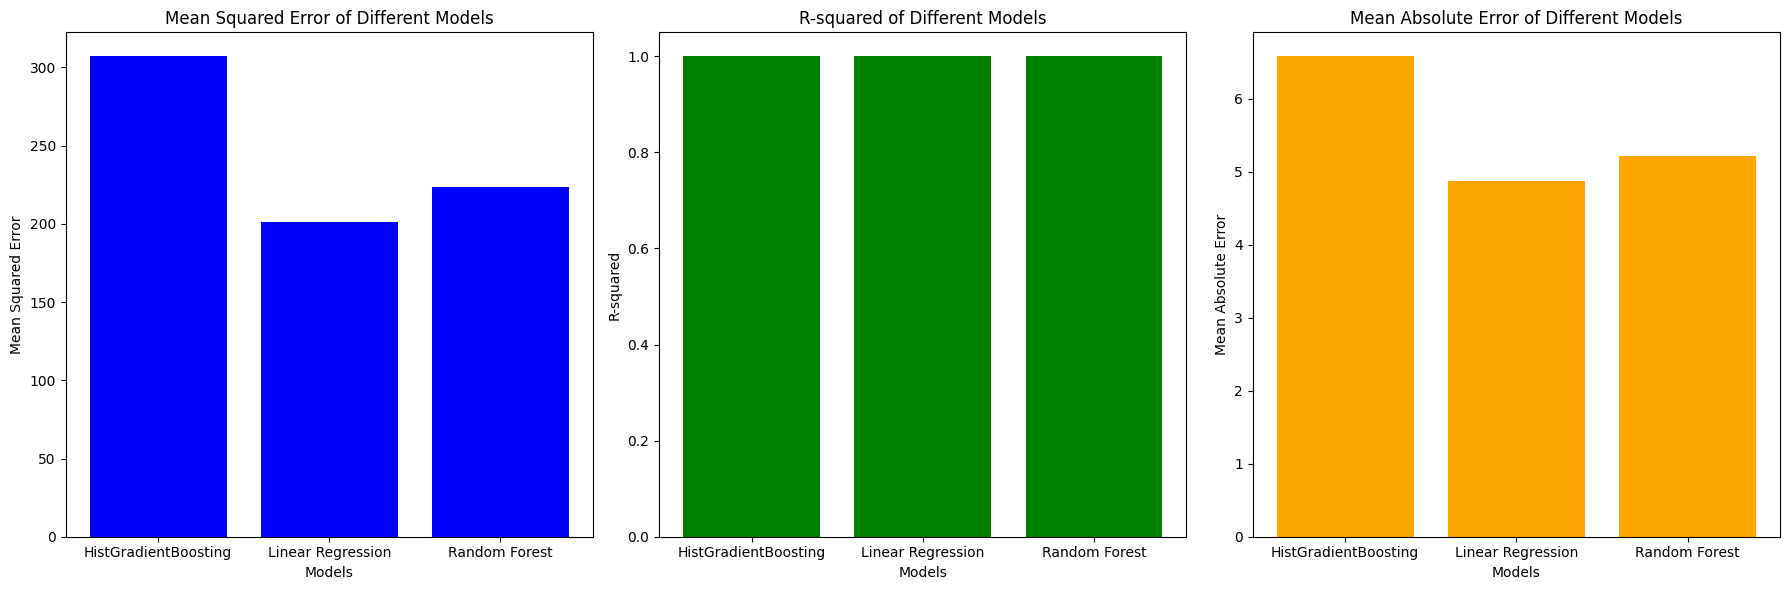

In [25]:
import matplotlib.pyplot as plt
import numpy as np
# Names of models
models = ['HistGradientBoosting', 'Linear Regression', 'Random Forest']

# Mean Squared Error values
mse_values = [mse_gradient_reg, mse_linear_reg, mse_random_forest]

# R-squared values
r2_values = [r2_gradient_reg, r2_linear_reg, r2_random_forest]

# Mean Absolute Error values
mae_values = [mae_gradient_reg, mae_linear_reg, mae_random_forest]

# Set up a figure with subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

# Plotting the Mean Squared Error
ax1.bar(models, mse_values, color='blue')
ax1.set_xlabel('Models')
ax1.set_ylabel('Mean Squared Error')
ax1.set_title('Mean Squared Error of Different Models')

# Plotting the R-squared values
ax2.bar(models, r2_values, color='green')
ax2.set_xlabel('Models')
ax2.set_ylabel('R-squared')
ax2.set_title('R-squared of Different Models')

# Plotting the Mean Absolute Error
ax3.bar(models, mae_values, color='orange')
ax3.set_xlabel('Models')
ax3.set_ylabel('Mean Absolute Error')
ax3.set_title('Mean Absolute Error of Different Models')

# Adjust the spacing between subplots
plt.tight_layout()

# Display the plot
plt.show()

